In [76]:
import glob
import sys 
import warnings
import os
import pandas as pd 

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"vladimirngu","key":"5b7e6a30cc5e84e59accf52a8a34bbc8"}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

dogs-vs-cats-redux-kernels-edition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip dogs-vs-cats-redux-kernels-edition.zip -d my_data
!unzip my_data/test.zip -d test_1
!unzip my_data/train.zip -d train_1

In [7]:
main_path = '/content/train_1'
#os.mkdir(main_path + '/Cat')
#os.mkdir(main_path + '/Dog')

In [17]:
def get_file_names(folder_path) -> list:
    file_paths = [f.path for f in os.scandir(folder_path) if not f.is_dir()]
    file_names = [f.split('/')[-1] for f in file_paths]

    return file_names

In [28]:
name = get_file_names('/content/train_1/train')
for j in range(len(name)):
  if name[j][:3] in 'dog':
    os.rename(f'/content/train_1/train/{name[j]}', f'/content/train_1/Dog/{name[j]}')
  else:
    os.rename(f'/content/train_1/train/{name[j]}', f'/content/train_1/Cat/{name[j]}')

In [30]:
os.rmdir('/content/train_1/train')

In [31]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

dataset = ImageFolder(
    "/content/train_1", 
    transform=Compose(
        [
            Resize((224, 224)), 
            ToTensor(), 
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )
)
train_set, test_set = torch.utils.data.random_split(
    dataset, 
    [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))]
)


In [32]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

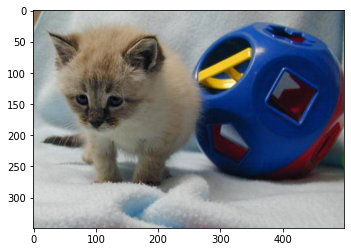

In [33]:
file = np.random.choice(glob.glob("/content/test_1/*/*.jpg"))
plt.imshow(plt.imread(file));

In [34]:
from pprint import PrettyPrinter
from torchvision.models import resnet18

# Загрузить предобученную сеть -- pretrained = True
model = resnet18(pretrained=True)
#model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [35]:
for param in model.parameters():
    param.requires_grad = False

In [36]:
model.fc = nn.Linear(512, 2)

In [37]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    criterion,
    return_losses=False,
    device="cpu",
):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics


    
def fit(
    model,
    epochs,
    train_data_loader,
    validation_data_loader,
    optimizer,
    criterion,
    device="cuda:0"
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion,
            device=device
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4) # обучаем только последние парметры
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [39]:
fit(model, 5, train_dataloader, test_dataloader, optimizer, criterion, device=device)

Train Epoch: 0


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 0


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 1


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 1


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 2


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 2


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 3


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 3


  0%|          | 0/20 [00:00<?, ?it/s]

Train Epoch: 4


  0%|          | 0/79 [00:00<?, ?it/s]

Validation Epoch: 4


  0%|          | 0/20 [00:00<?, ?it/s]

In [69]:
dataset = ImageFolder(
    "/content/test_1", 
    transform=Compose(
        [
            Resize((224, 224)), 
            ToTensor(), 
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )
)
set_test = torch.utils.data.DataLoader(dataset, batch_size=256)

In [72]:
prediction = np.array([])
for j, i in tqdm(set_test):
  j = j.to(device)
  predict = model(j)
  prediction = np.append(prediction, predict.argmax(1).cpu().detach().numpy())

  0%|          | 0/49 [00:00<?, ?it/s]

In [107]:
total_pred = pd.DataFrame(prediction, columns=['label']).reset_index().rename(columns={'index':'id'})
total_pred.id = total_pred.id + 1
total_pred = total_pred.set_index('id')
total_pred.to_csv('all_pred.csv')

,label
id,
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0
...,...
12495,0.0
12496,1.0
12497,1.0
